# ODE Integration Tutorial

This tutorial demonstrates how to use the ordinary differential equation (ODE) integrators in BrainTools. We'll cover:

1. **Basic integrators**: Euler, RK2, RK3, RK4
2. **Advanced integrators**: Embedded methods with error estimation
3. **Specialized methods**: Exponential Euler, Strong Stability Preserving
4. **Performance comparison and accuracy analysis**
5. **Practical neuroscience examples**

All integrators in BrainTools operate on JAX PyTrees and use the global time step from `brainstate.environ`.

## Setup and Imports

In [1]:
import brainstate
import brainunit as u
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
import numpy as np

import braintools

# Set up plotting style
plt.style.use('seaborn-v0_8')
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 12

# Enable JAX's float64 for better precision in this tutorial
jax.config.update("jax_enable_x64", True)

## 1. Basic ODE Integrators

Let's start with a simple example: the exponential decay equation.

$$\frac{dy}{dt} = -\lambda y, \quad y(0) = y_0$$

The analytical solution is $y(t) = y_0 e^{-\lambda t}$.

In [2]:
# Define the ODE
def exponential_decay(y, t, lam=1.0):
    """dy/dt = -lambda * y"""
    return -lam * y


# Analytical solution
def analytical_solution(t, y0=1.0, lam=1.0):
    return y0 * jnp.exp(-lam * t)


# Integration parameters
y0 = 1.0
t_final = 3.0
dt = 0.1
lam = 1.0

# Time array
t_array = jnp.arange(0, t_final + dt, dt)
n_steps = len(t_array) - 1

print(f"Integration from t=0 to t={t_final} with dt={dt}")
print(f"Number of steps: {n_steps}")

Integration from t=0 to t=3.0 with dt=0.1
Number of steps: 30


### Euler Method

The simplest first-order method: $y_{n+1} = y_n + \Delta t \cdot f(y_n, t_n)$

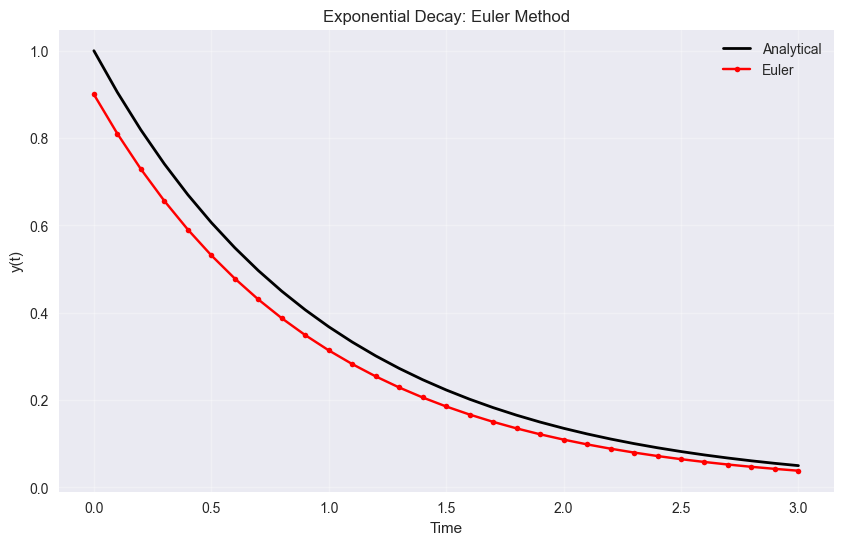

Euler method final error: 0.011635


In [3]:
# Integrate using Euler method
def integrate_ode(integrator_func, f, y0, t_array, *args):
    """Generic ODE integration function"""
    dt = t_array[1] - t_array[0]
    y = y0

    def step_run(y0, t):
        y1 = integrator_func(f, y0, t, *args)
        return y1, y1

    with brainstate.environ.context(dt=dt):
        y, y_values = brainstate.transform.scan(step_run, y, t_array)
    return jax.block_until_ready(y_values)


# Integrate with Euler method
y_euler = integrate_ode(braintools.quad.ode_euler_step, exponential_decay, y0, t_array, lam)

# Plot results
plt.figure(figsize=(10, 6))
plt.plot(t_array, analytical_solution(t_array, y0, lam), 'k-', linewidth=2, label='Analytical')
plt.plot(t_array, y_euler, 'ro-', markersize=4, label='Euler')
plt.xlabel('Time')
plt.ylabel('y(t)')
plt.title('Exponential Decay: Euler Method')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# Calculate error
analytical = analytical_solution(t_array, y0, lam)
error_euler = jnp.abs(y_euler - analytical)
print(f"Euler method final error: {error_euler[-1]:.6f}")

### Runge-Kutta Methods

Let's compare different orders of Runge-Kutta methods:

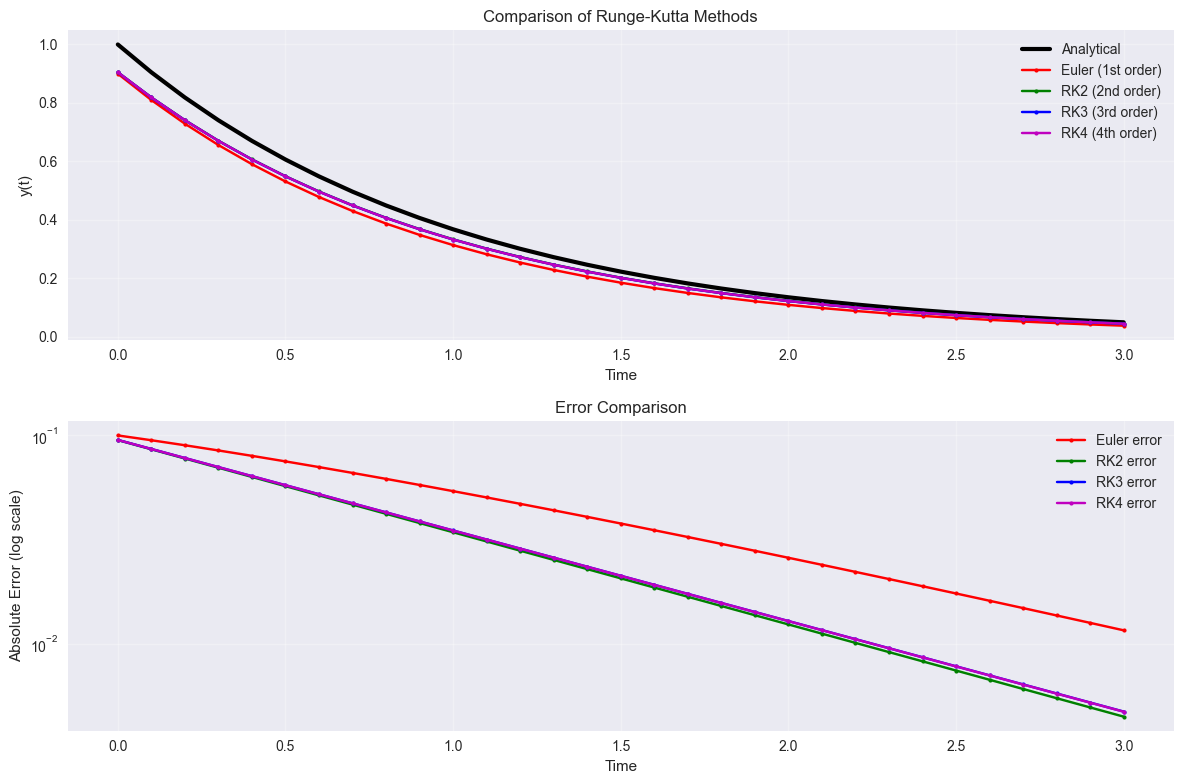

Final errors:
Euler:  1.16e-02
RK2:    4.49e-03
RK3:    4.74e-03
RK4:    4.74e-03


In [4]:
# Integrate with different RK methods
y_rk2 = integrate_ode(braintools.quad.ode_rk2_step, exponential_decay, y0, t_array, lam)
y_rk3 = integrate_ode(braintools.quad.ode_rk3_step, exponential_decay, y0, t_array, lam)
y_rk4 = integrate_ode(braintools.quad.ode_rk4_step, exponential_decay, y0, t_array, lam)

# Plot comparison
plt.figure(figsize=(12, 8))

# Main plot
plt.subplot(2, 1, 1)
plt.plot(t_array, analytical, 'k-', linewidth=3, label='Analytical')
plt.plot(t_array, y_euler, 'ro-', markersize=3, label='Euler (1st order)')
plt.plot(t_array, y_rk2, 'go-', markersize=3, label='RK2 (2nd order)')
plt.plot(t_array, y_rk3, 'bo-', markersize=3, label='RK3 (3rd order)')
plt.plot(t_array, y_rk4, 'mo-', markersize=3, label='RK4 (4th order)')
plt.xlabel('Time')
plt.ylabel('y(t)')
plt.title('Comparison of Runge-Kutta Methods')
plt.legend()
plt.grid(True, alpha=0.3)

# Error plot
plt.subplot(2, 1, 2)
error_rk2 = jnp.abs(y_rk2 - analytical)
error_rk3 = jnp.abs(y_rk3 - analytical)
error_rk4 = jnp.abs(y_rk4 - analytical)

plt.semilogy(t_array, error_euler, 'ro-', markersize=3, label='Euler error')
plt.semilogy(t_array, error_rk2, 'go-', markersize=3, label='RK2 error')
plt.semilogy(t_array, error_rk3, 'bo-', markersize=3, label='RK3 error')
plt.semilogy(t_array, error_rk4, 'mo-', markersize=3, label='RK4 error')
plt.xlabel('Time')
plt.ylabel('Absolute Error (log scale)')
plt.title('Error Comparison')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Print final errors
print("Final errors:")
print(f"Euler:  {error_euler[-1]:.2e}")
print(f"RK2:    {error_rk2[-1]:.2e}")
print(f"RK3:    {error_rk3[-1]:.2e}")
print(f"RK4:    {error_rk4[-1]:.2e}")

## 2. Embedded Methods with Error Estimation

Embedded methods provide automatic error estimation by computing solutions of two different orders. Let's demonstrate this with the Bogacki-Shampine 2(3) and Dormand-Prince 5(4) methods.

In [5]:
def integrate_ode_with_error(integrator_func, f, y0, t_array, *args):
    """Integration function that returns both solution and error estimates"""
    dt = t_array[1] - t_array[0]
    y = y0

    def step_run(y0, t):
        y1, err = integrator_func(f, y0, t, *args, return_error=True)
        return y1, (y1, err)

    with brainstate.environ.context(dt=dt):
        y, (y_values, errors) = brainstate.transform.scan(step_run, y, t_array)

    return y_values, jax.block_until_ready(errors)

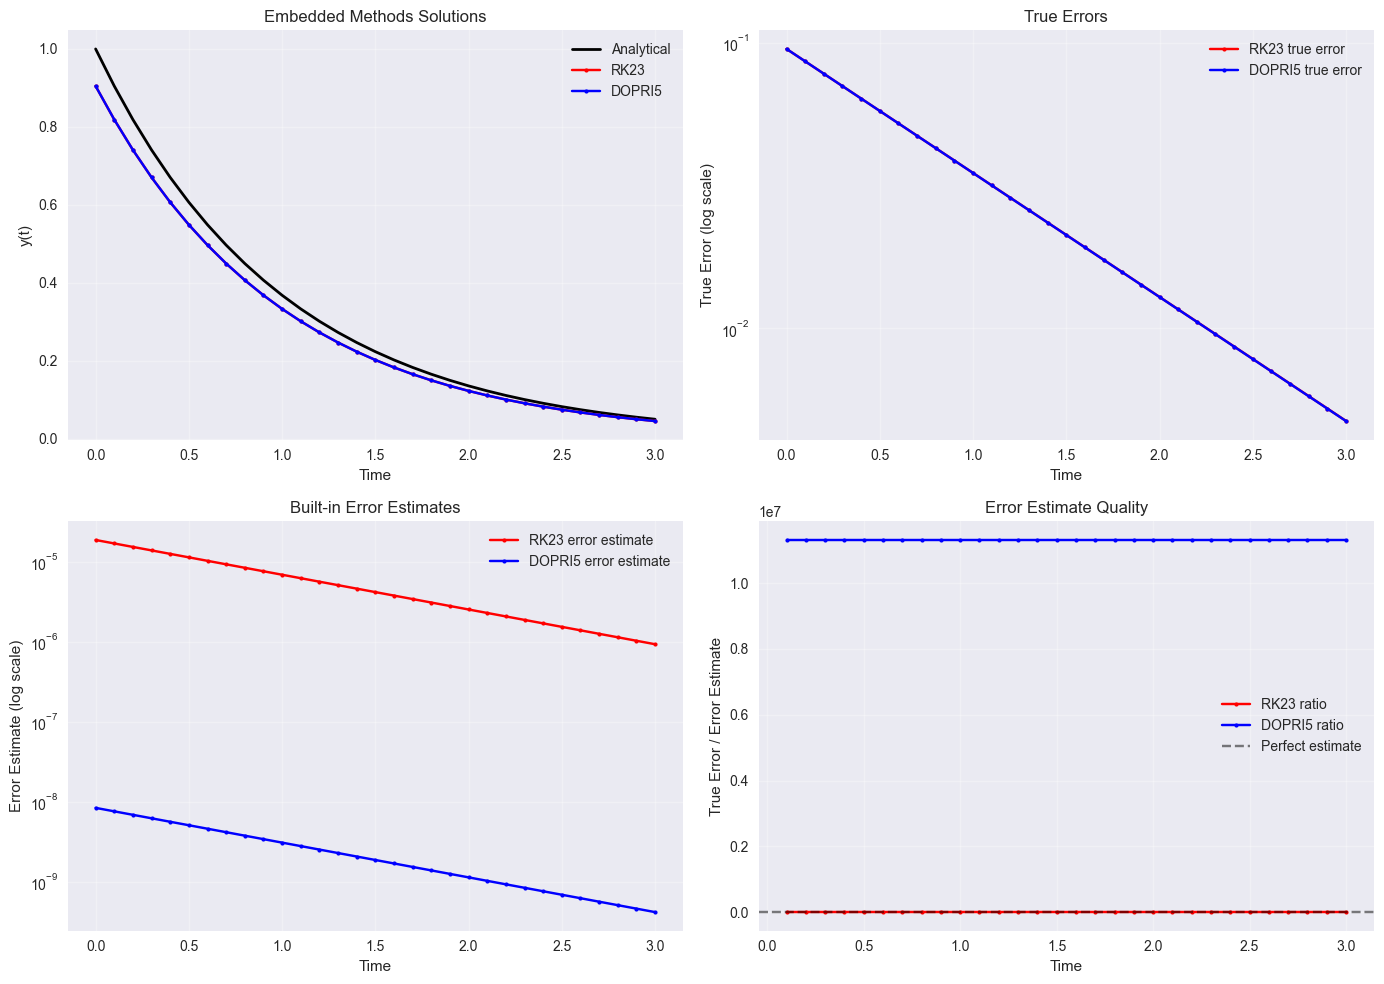


Error estimate quality (closer to 1 is better):
RK23 mean ratio: 5079.29 ± 2.08
DOPRI5 mean ratio: 11312044.76 ± 0.32


In [6]:
# Integrate with embedded methods
y_rk23, err_rk23 = integrate_ode_with_error(braintools.quad.ode_rk23_step, exponential_decay, y0, t_array, lam)
y_dopri5, err_dopri5 = integrate_ode_with_error(braintools.quad.ode_dopri5_step, exponential_decay, y0, t_array, lam)

# Plot results with error estimates
plt.figure(figsize=(14, 10))

# Solution comparison
plt.subplot(2, 2, 1)
plt.plot(t_array, analytical, 'k-', linewidth=2, label='Analytical')
plt.plot(t_array, y_rk23, 'ro-', markersize=3, label='RK23')
plt.plot(t_array, y_dopri5, 'bo-', markersize=3, label='DOPRI5')
plt.xlabel('Time')
plt.ylabel('y(t)')
plt.title('Embedded Methods Solutions')
plt.legend()
plt.grid(True, alpha=0.3)

# True errors
plt.subplot(2, 2, 2)
true_err_rk23 = jnp.abs(y_rk23 - analytical)
true_err_dopri5 = jnp.abs(y_dopri5 - analytical)
plt.semilogy(t_array, true_err_rk23, 'ro-', markersize=3, label='RK23 true error')
plt.semilogy(t_array, true_err_dopri5, 'bo-', markersize=3, label='DOPRI5 true error')
plt.xlabel('Time')
plt.ylabel('True Error (log scale)')
plt.title('True Errors')
plt.legend()
plt.grid(True, alpha=0.3)

# Error estimates
plt.subplot(2, 2, 3)
plt.semilogy(t_array, jnp.abs(err_rk23), 'ro-', markersize=3, label='RK23 error estimate')
plt.semilogy(t_array, jnp.abs(err_dopri5), 'bo-', markersize=3, label='DOPRI5 error estimate')
plt.xlabel('Time')
plt.ylabel('Error Estimate (log scale)')
plt.title('Built-in Error Estimates')
plt.legend()
plt.grid(True, alpha=0.3)

# Error estimate quality
plt.subplot(2, 2, 4)
ratio_rk23 = true_err_rk23[1:] / jnp.abs(err_rk23[1:])  # Skip first point (zero error)
ratio_dopri5 = true_err_dopri5[1:] / jnp.abs(err_dopri5[1:])
plt.plot(t_array[1:], ratio_rk23, 'ro-', markersize=3, label='RK23 ratio')
plt.plot(t_array[1:], ratio_dopri5, 'bo-', markersize=3, label='DOPRI5 ratio')
plt.axhline(y=1, color='k', linestyle='--', alpha=0.5, label='Perfect estimate')
plt.xlabel('Time')
plt.ylabel('True Error / Error Estimate')
plt.title('Error Estimate Quality')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\nError estimate quality (closer to 1 is better):")
print(f"RK23 mean ratio: {jnp.mean(ratio_rk23):.2f} ± {jnp.std(ratio_rk23):.2f}")
print(f"DOPRI5 mean ratio: {jnp.mean(ratio_dopri5):.2f} ± {jnp.std(ratio_dopri5):.2f}")

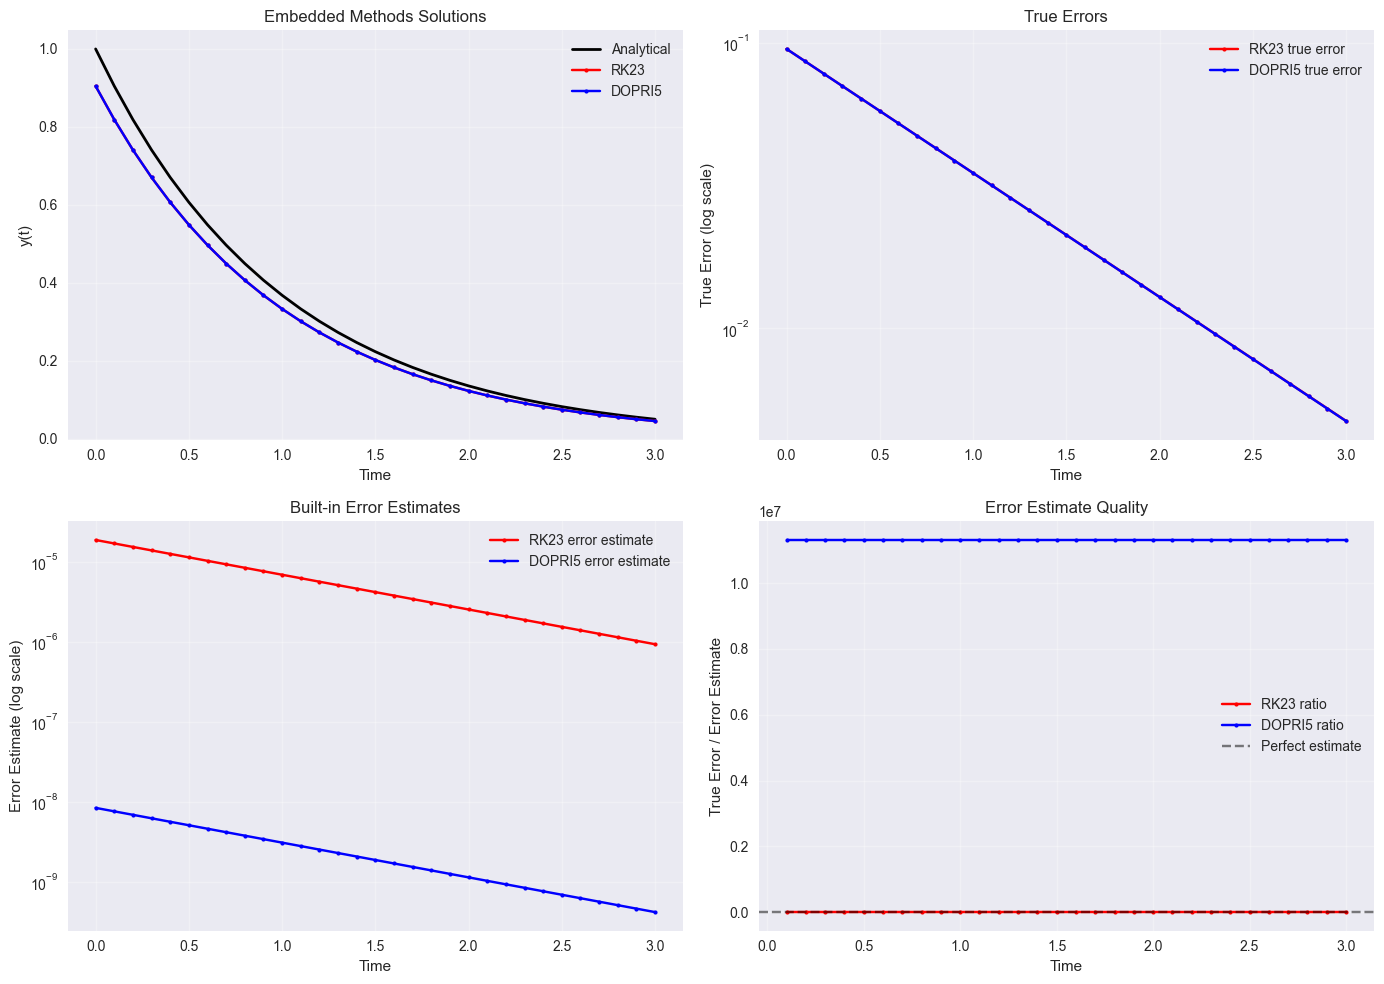


Error estimate quality (closer to 1 is better):
RK23 mean ratio: 5079.29 ± 2.08
DOPRI5 mean ratio: 11312044.76 ± 0.32


In [7]:
# Integrate with embedded methods
y_rk23, err_rk23 = integrate_ode_with_error(braintools.quad.ode_rk23_step, exponential_decay, y0, t_array, lam)
y_dopri5, err_dopri5 = integrate_ode_with_error(braintools.quad.ode_dopri5_step, exponential_decay, y0, t_array, lam)

# Plot results with error estimates
plt.figure(figsize=(14, 10))

# Solution comparison
plt.subplot(2, 2, 1)
plt.plot(t_array, analytical, 'k-', linewidth=2, label='Analytical')
plt.plot(t_array, y_rk23, 'ro-', markersize=3, label='RK23')
plt.plot(t_array, y_dopri5, 'bo-', markersize=3, label='DOPRI5')
plt.xlabel('Time')
plt.ylabel('y(t)')
plt.title('Embedded Methods Solutions')
plt.legend()
plt.grid(True, alpha=0.3)

# True errors
plt.subplot(2, 2, 2)
true_err_rk23 = jnp.abs(y_rk23 - analytical)
true_err_dopri5 = jnp.abs(y_dopri5 - analytical)
plt.semilogy(t_array, true_err_rk23, 'ro-', markersize=3, label='RK23 true error')
plt.semilogy(t_array, true_err_dopri5, 'bo-', markersize=3, label='DOPRI5 true error')
plt.xlabel('Time')
plt.ylabel('True Error (log scale)')
plt.title('True Errors')
plt.legend()
plt.grid(True, alpha=0.3)

# Error estimates
plt.subplot(2, 2, 3)
plt.semilogy(t_array, jnp.abs(err_rk23), 'ro-', markersize=3, label='RK23 error estimate')
plt.semilogy(t_array, jnp.abs(err_dopri5), 'bo-', markersize=3, label='DOPRI5 error estimate')
plt.xlabel('Time')
plt.ylabel('Error Estimate (log scale)')
plt.title('Built-in Error Estimates')
plt.legend()
plt.grid(True, alpha=0.3)

# Error estimate quality
plt.subplot(2, 2, 4)
ratio_rk23 = true_err_rk23[1:] / jnp.abs(err_rk23[1:])  # Skip first point (zero error)
ratio_dopri5 = true_err_dopri5[1:] / jnp.abs(err_dopri5[1:])
plt.plot(t_array[1:], ratio_rk23, 'ro-', markersize=3, label='RK23 ratio')
plt.plot(t_array[1:], ratio_dopri5, 'bo-', markersize=3, label='DOPRI5 ratio')
plt.axhline(y=1, color='k', linestyle='--', alpha=0.5, label='Perfect estimate')
plt.xlabel('Time')
plt.ylabel('True Error / Error Estimate')
plt.title('Error Estimate Quality')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\nError estimate quality (closer to 1 is better):")
print(f"RK23 mean ratio: {jnp.mean(ratio_rk23):.2f} ± {jnp.std(ratio_rk23):.2f}")
print(f"DOPRI5 mean ratio: {jnp.mean(ratio_dopri5):.2f} ± {jnp.std(ratio_dopri5):.2f}")

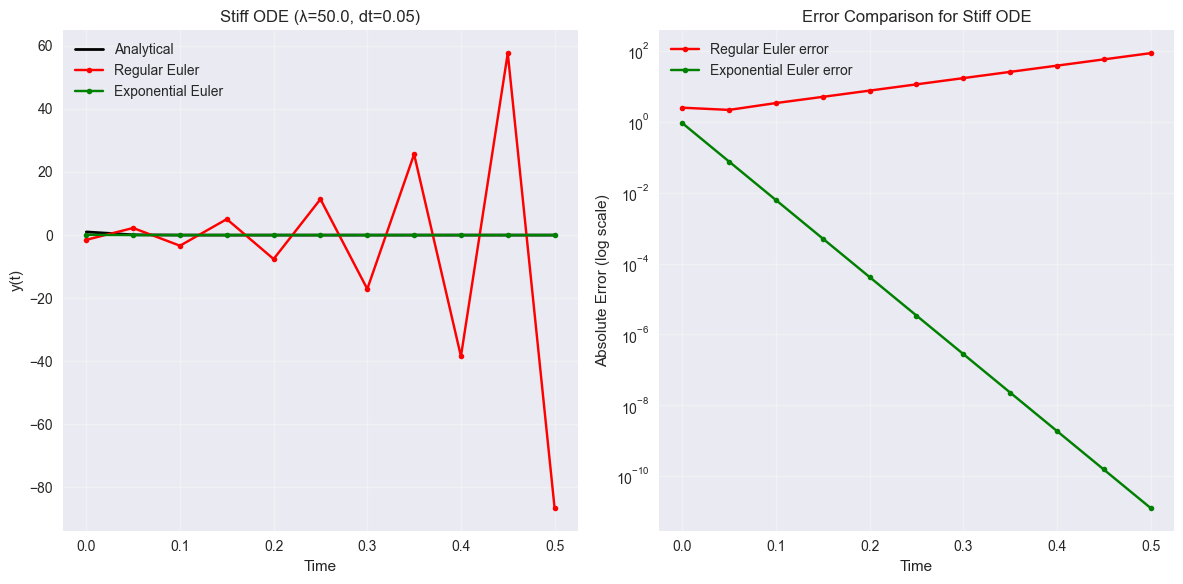

Final errors for stiff ODE:
Regular Euler:      8.65e+01
Exponential Euler:  1.27e-11
Improvement factor: 6785212127633.2x


In [8]:
# Test exponential Euler on a stiff problem
def stiff_ode(y, t, lam=50.0):
    """A stiff ODE: dy/dt = -lambda * y with large lambda"""
    return -lam * y


# Parameters for stiff problem
lam_stiff = 50.0
dt_stiff = 0.05  # Relatively large step size
t_final_stiff = 0.5
t_array_stiff = jnp.arange(0, t_final_stiff + dt_stiff, dt_stiff)

# Analytical solution
analytical_stiff = analytical_solution(t_array_stiff, y0, lam_stiff)

# Compare regular Euler vs Exponential Euler
y_euler_stiff = integrate_ode(braintools.quad.ode_euler_step, stiff_ode, y0, t_array_stiff, lam_stiff)
y_expeuler_stiff = integrate_ode(braintools.quad.ode_expeuler_step, stiff_ode, y0, t_array_stiff, lam_stiff)

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(t_array_stiff, analytical_stiff, 'k-', linewidth=2, label='Analytical')
plt.plot(t_array_stiff, y_euler_stiff, 'ro-', markersize=4, label='Regular Euler')
plt.plot(t_array_stiff, y_expeuler_stiff, 'go-', markersize=4, label='Exponential Euler')
plt.xlabel('Time')
plt.ylabel('y(t)')
plt.title(f'Stiff ODE (λ={lam_stiff}, dt={dt_stiff})')
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
error_euler_stiff = jnp.abs(y_euler_stiff - analytical_stiff)
error_expeuler_stiff = jnp.abs(y_expeuler_stiff - analytical_stiff)
plt.semilogy(t_array_stiff, error_euler_stiff, 'ro-', markersize=4, label='Regular Euler error')
plt.semilogy(t_array_stiff, error_expeuler_stiff, 'go-', markersize=4, label='Exponential Euler error')
plt.xlabel('Time')
plt.ylabel('Absolute Error (log scale)')
plt.title('Error Comparison for Stiff ODE')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"Final errors for stiff ODE:")
print(f"Regular Euler:      {error_euler_stiff[-1]:.2e}")
print(f"Exponential Euler:  {error_expeuler_stiff[-1]:.2e}")
print(f"Improvement factor: {error_euler_stiff[-1] / error_expeuler_stiff[-1]:.1f}x")

### Strong Stability Preserving RK (SSPRK)

SSPRK methods are designed to preserve certain stability properties, particularly useful for hyperbolic PDEs and conservation laws.

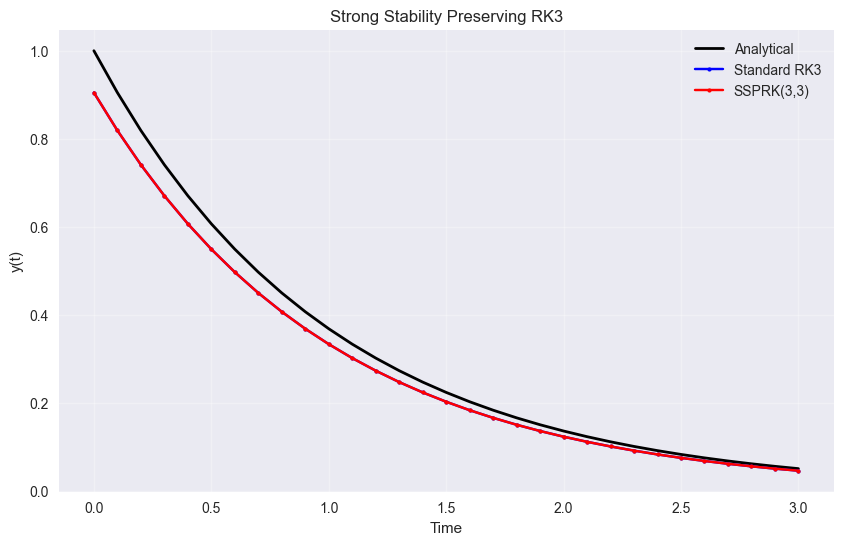

SSPRK(3,3) final error: 4.74e-03
Standard RK3 final error: 4.74e-03


In [9]:
# Test SSPRK33 method
y_ssprk33 = integrate_ode(braintools.quad.ode_ssprk33_step, exponential_decay, y0, t_array, lam)

plt.figure(figsize=(10, 6))
plt.plot(t_array, analytical, 'k-', linewidth=2, label='Analytical')
plt.plot(t_array, y_rk3, 'bo-', markersize=3, label='Standard RK3')
plt.plot(t_array, y_ssprk33, 'ro-', markersize=3, label='SSPRK(3,3)')
plt.xlabel('Time')
plt.ylabel('y(t)')
plt.title('Strong Stability Preserving RK3')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

error_ssprk33 = jnp.abs(y_ssprk33 - analytical)
print(f"SSPRK(3,3) final error: {error_ssprk33[-1]:.2e}")
print(f"Standard RK3 final error: {error_rk3[-1]:.2e}")

## 4. Step Size Analysis

Let's analyze how the error scales with step size for different methods to verify their theoretical order of accuracy.

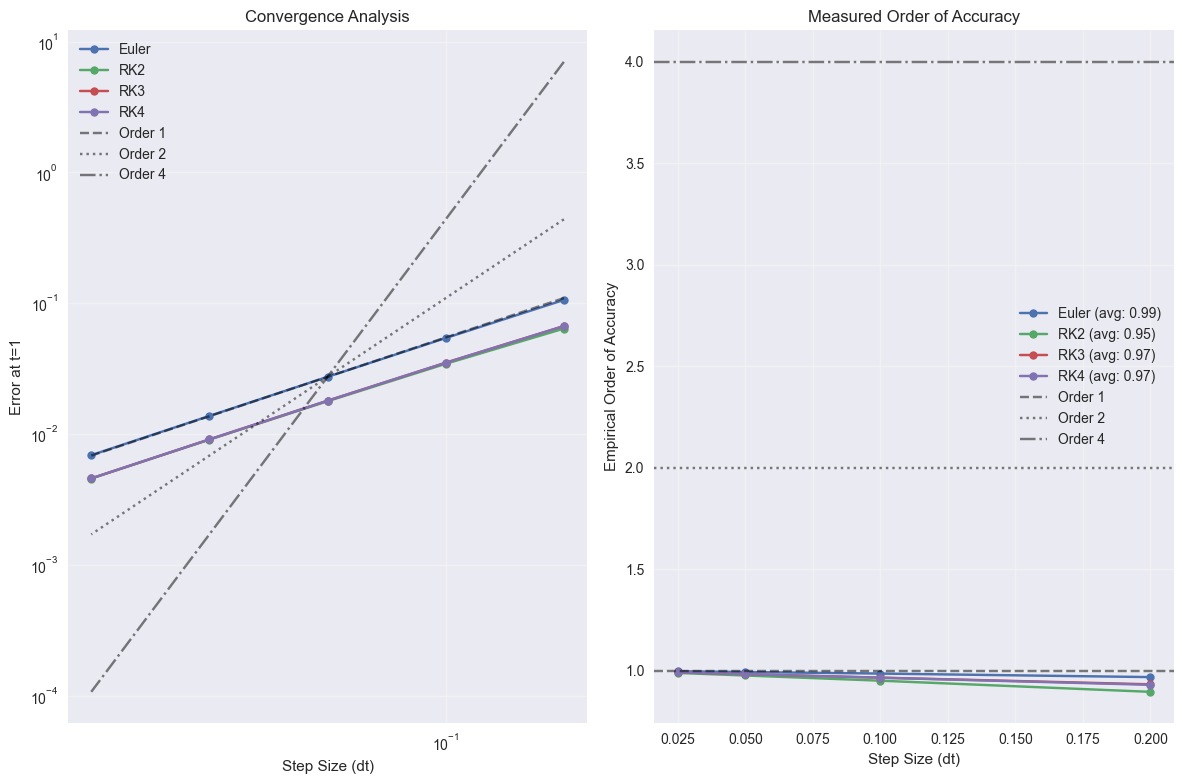

Average empirical orders of accuracy:
Euler: 0.99
RK2: 0.95
RK3: 0.97
RK4: 0.97


In [10]:
# Step size convergence study
dt_values = jnp.array([0.2, 0.1, 0.05, 0.025, 0.0125])
t_final_conv = 1.0

methods = {
    'Euler': braintools.quad.ode_euler_step,
    'RK2': braintools.quad.ode_rk2_step,
    'RK3': braintools.quad.ode_rk3_step,
    'RK4': braintools.quad.ode_rk4_step
}

errors = {name: [] for name in methods.keys()}

for dt in dt_values:
    t_array_conv = jnp.arange(0, t_final_conv + dt, dt)
    analytical_conv = analytical_solution(t_array_conv, y0, lam)

    for name, method in methods.items():
        y_numerical = integrate_ode(method, exponential_decay, y0, t_array_conv, lam)
        error = jnp.abs(y_numerical[-1] - analytical_conv[-1])
        errors[name].append(error)

# Convert to arrays
for name in errors.keys():
    errors[name] = jnp.array(errors[name])

# Plot convergence
plt.figure(figsize=(12, 8))

plt.subplot(1, 2, 1)
for name in methods.keys():
    plt.loglog(dt_values, errors[name], 'o-', markersize=6, label=name)

# Add theoretical slopes
dt_ref = dt_values[2]
error_ref = errors['Euler'][2]
plt.loglog(dt_values, error_ref * (dt_values / dt_ref) ** 1, 'k--', alpha=0.5, label='Order 1')
plt.loglog(dt_values, error_ref * (dt_values / dt_ref) ** 2, 'k:', alpha=0.5, label='Order 2')
plt.loglog(dt_values, error_ref * (dt_values / dt_ref) ** 4, 'k-.', alpha=0.5, label='Order 4')

plt.xlabel('Step Size (dt)')
plt.ylabel('Error at t=1')
plt.title('Convergence Analysis')
plt.legend()
plt.grid(True, alpha=0.3)

# Calculate empirical order of accuracy
plt.subplot(1, 2, 2)
orders = {}
for name in methods.keys():
    order_estimates = []
    for i in range(len(dt_values) - 1):
        order = jnp.log(errors[name][i] / errors[name][i + 1]) / jnp.log(dt_values[i] / dt_values[i + 1])
        order_estimates.append(order)
    orders[name] = jnp.array(order_estimates)
    plt.plot(
        dt_values[:-1],
        order_estimates,
        'o-',
        markersize=6,
        label=f'{name} (avg: {np.mean(order_estimates):.2f})'
    )

plt.axhline(y=1, color='k', linestyle='--', alpha=0.5, label='Order 1')
plt.axhline(y=2, color='k', linestyle=':', alpha=0.5, label='Order 2')
plt.axhline(y=4, color='k', linestyle='-.', alpha=0.5, label='Order 4')
plt.xlabel('Step Size (dt)')
plt.ylabel('Empirical Order of Accuracy')
plt.title('Measured Order of Accuracy')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("Average empirical orders of accuracy:")
for name in methods.keys():
    print(f"{name}: {jnp.mean(orders[name]):.2f}")

## 5. Practical Neuroscience Example: Hodgkin-Huxley Neuron

Let's solve a simplified version of the Hodgkin-Huxley equations for a single neuron compartment.

In [11]:
class HH(brainstate.nn.Dynamics):
    def __init__(
        self,
        in_size,
        ENa=50. * u.mV,
        gNa=120. * u.mS / u.cm ** 2,
        EK=-77. * u.mV,
        gK=36. * u.mS / u.cm ** 2,
        EL=-54.387 * u.mV,
        gL=0.03 * u.mS / u.cm ** 2,
        V_th=20. * u.mV,
        C=1.0 * u.uF / u.cm ** 2,
        method=braintools.quad.ode_rk87_dopri_step,
    ):
        # initialization
        super().__init__(in_size)

        # parameters
        self.ENa = ENa
        self.EK = EK
        self.EL = EL
        self.gNa = gNa
        self.gK = gK
        self.gL = gL
        self.C = C
        self.V_th = V_th
        self.method = method

    # m channel
    m_alpha = lambda self, V: 1. / u.math.exprel(-(V / u.mV + 40) / 10)
    m_beta = lambda self, V: 4.0 * jnp.exp(-(V / u.mV + 65) / 18)
    m_inf = lambda self, V: self.m_alpha(V) / (self.m_alpha(V) + self.m_beta(V))
    dm = lambda self, m, t, V: (self.m_alpha(V) * (1 - m) - self.m_beta(V) * m) / u.ms

    # h channel
    h_alpha = lambda self, V: 0.07 * jnp.exp(-(V / u.mV + 65) / 20.)
    h_beta = lambda self, V: 1 / (1 + jnp.exp(-(V / u.mV + 35) / 10))
    h_inf = lambda self, V: self.h_alpha(V) / (self.h_alpha(V) + self.h_beta(V))
    dh = lambda self, h, t, V: (self.h_alpha(V) * (1 - h) - self.h_beta(V) * h) / u.ms

    # n channel
    n_alpha = lambda self, V: 0.1 / u.math.exprel(-(V / u.mV + 55) / 10)
    n_beta = lambda self, V: 0.125 * jnp.exp(-(V / u.mV + 65) / 80)
    n_inf = lambda self, V: self.n_alpha(V) / (self.n_alpha(V) + self.n_beta(V))
    dn = lambda self, n, t, V: (self.n_alpha(V) * (1 - n) - self.n_beta(V) * n) / u.ms

    def init_state(self, batch_size=None):
        self.V = brainstate.HiddenState(jnp.ones(self.varshape) * -65. * u.mV)
        self.m = brainstate.HiddenState(self.m_inf(self.V.value))
        self.h = brainstate.HiddenState(self.h_inf(self.V.value))
        self.n = brainstate.HiddenState(self.n_inf(self.V.value))

    def dV(self, V, t, m, h, n, I):
        I = self.sum_current_inputs(I, V)
        I_Na = (self.gNa * m * m * m * h) * (V - self.ENa)
        n2 = n * n
        I_K = (self.gK * n2 * n2) * (V - self.EK)
        I_leak = self.gL * (V - self.EL)
        dVdt = (- I_Na - I_K - I_leak + I) / self.C
        return dVdt

    def derivative(self, state, t, inp):
        V, m, h, n = state
        dV = self.dV(V, t, m, h, n, inp)
        dm = self.dm(m, t, V)
        dh = self.dh(h, t, V)
        dn = self.dn(n, t, V)
        return dV, dm, dh, dn

    def update(self, x=0. * u.mA / u.cm ** 2):
        t = brainstate.environ.get('t')
        V, m, h, n = self.method(
            self.derivative,
            (self.V.value, self.m.value, self.h.value, self.n.value),
            0. * u.ms,
            x
        )

        V = self.sum_delta_inputs(init=V)
        spike = jnp.logical_and(self.V.value < self.V_th, V >= self.V_th)
        self.V.value = V
        self.m.value = m
        self.h.value = h
        self.n.value = n
        return spike

    def step_run(self, i, inp):
        with brainstate.environ.context(t=i * brainstate.environ.get_dt(), i=i):
            spike = self.update(inp)
            return self.V.value, self.m.value, self.h.value, self.n.value

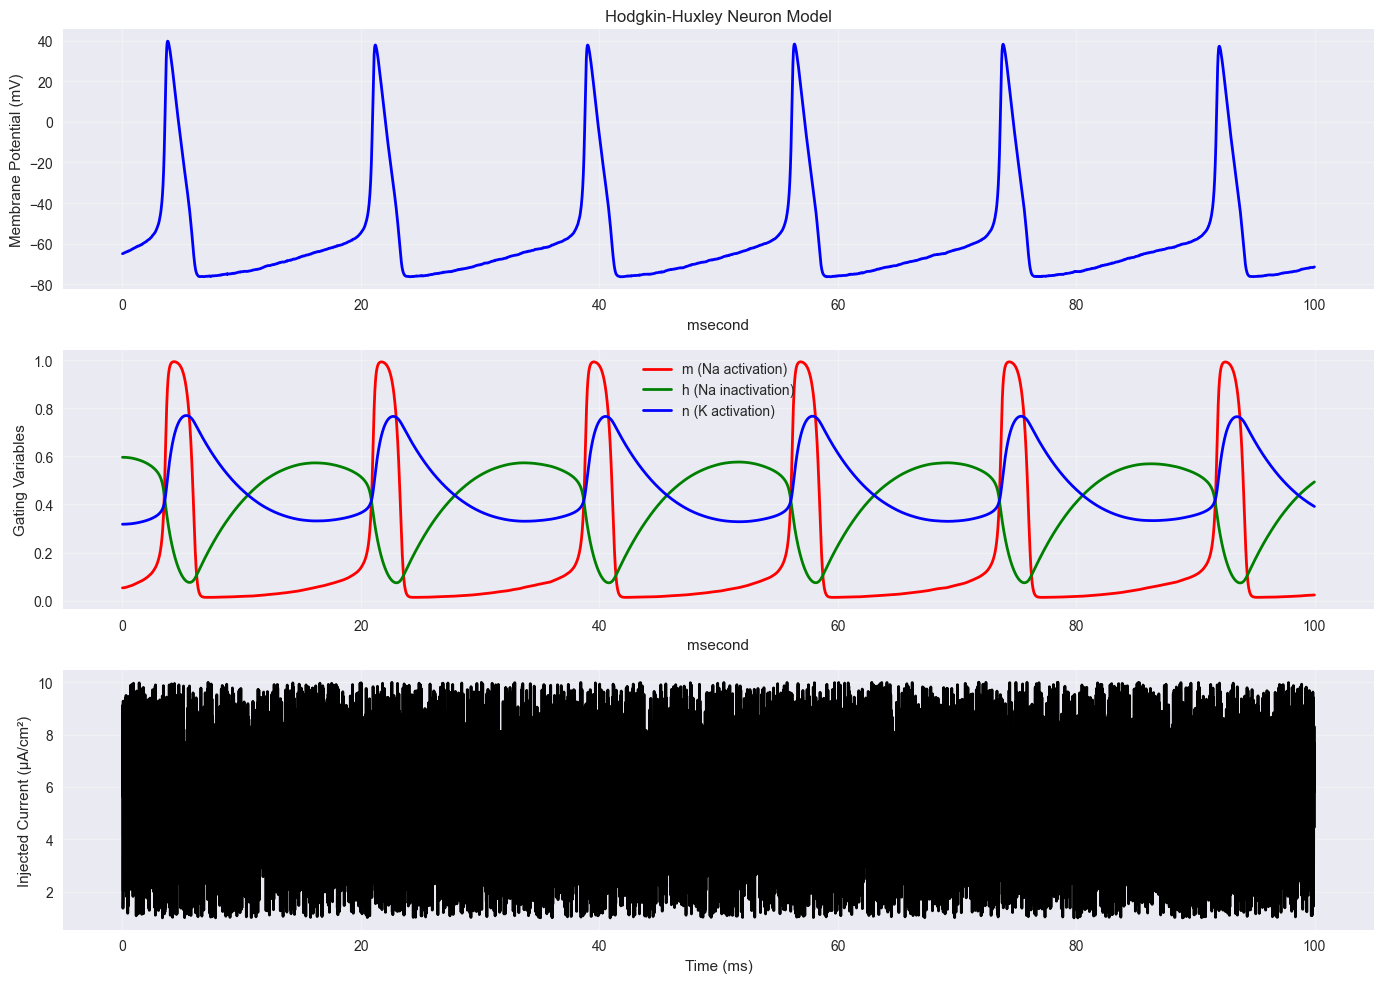

Peak membrane potential: 39.7 * mvolt
Resting potential: ArrayImpl([-64.9]) * mvolt


In [12]:
brainstate.environ.set(dt=0.01 * u.ms)
indices = np.arange(10000)
t_array_hh = indices * brainstate.environ.get_dt()

hh = HH(in_size=1, method=braintools.quad.ode_rk4_step)
hh.init_state()
I_ext_array = brainstate.random.uniform(1., 10., indices.shape) * u.uA / u.cm ** 2
V_hh, m_hh, h_hh, n_hh = brainstate.transform.for_loop(hh.step_run, indices, I_ext_array)
V_hh = jax.block_until_ready(V_hh)

# Plot results
plt.figure(figsize=(14, 10))

plt.subplot(3, 1, 1)
plt.plot(t_array_hh, V_hh, 'b-', linewidth=2)
plt.ylabel('Membrane Potential (mV)')
plt.title('Hodgkin-Huxley Neuron Model')
plt.grid(True, alpha=0.3)

plt.subplot(3, 1, 2)
plt.plot(t_array_hh, m_hh, 'r-', label='m (Na activation)', linewidth=2)
plt.plot(t_array_hh, h_hh, 'g-', label='h (Na inactivation)', linewidth=2)
plt.plot(t_array_hh, n_hh, 'b-', label='n (K activation)', linewidth=2)
plt.ylabel('Gating Variables')
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(3, 1, 3)
plt.plot(t_array_hh, I_ext_array, 'k-', linewidth=2)
plt.xlabel('Time (ms)')
plt.ylabel('Injected Current (μA/cm²)')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"Peak membrane potential: {V_hh.max():.1f}")
print(f"Resting potential: {V_hh[0]:.1f}")

## 6. Performance Considerations

Let's compare the computational efficiency of different methods.

In [13]:
import time


# Timing test setup
def time_integrator(integrator_func, f, y0, n_steps, dt_val, *args):
    """Time an integrator over n_steps"""
    t_array_timing = jnp.arange(0, n_steps * dt_val, dt_val)

    # Warm-up run (for JAX compilation)
    _ = integrate_ode(integrator_func, f, y0, t_array_timing[:10], *args)

    # Actual timing
    start_time = time.time()
    result = integrate_ode(integrator_func, f, y0, t_array_timing, *args)
    end_time = time.time()

    return end_time - start_time, result[-1]


# Timing parameters
n_steps_timing = 1000
dt_timing = 0.01

timing_methods = {
    'Euler': braintools.quad.ode_euler_step,
    'RK2': braintools.quad.ode_rk2_step,
    'RK4': braintools.quad.ode_rk4_step,
    'DOPRI5': braintools.quad.ode_dopri5_step,
}

times = {}
final_values = {}

print("Timing integrators over {} steps...".format(n_steps_timing))
for name, method in timing_methods.items():
    elapsed, final_val = time_integrator(method, exponential_decay, y0, n_steps_timing, dt_timing, lam)
    times[name] = elapsed
    final_values[name] = final_val
    print(f"{name:8s}: {elapsed:.4f} seconds, final value: {final_val:.6f}")

# Efficiency analysis
euler_time = times['Euler']
print("\nRelative timing (vs Euler):")
for name, time_val in times.items():
    print(f"{name:8s}: {time_val / euler_time:.2f}x")

# Accuracy per computational cost
analytical_final = analytical_solution(n_steps_timing * dt_timing, y0, lam)
print("\nAccuracy per computational cost:")
for name in timing_methods.keys():
    error = jnp.abs(final_values[name] - analytical_final)
    efficiency = 1.0 / (error * times[name])  # Higher is better
    print(f"{name:8s}: error={error:.2e}, efficiency={efficiency:.2e}")

Timing integrators over 1000 steps...
Euler   : 0.0450 seconds, final value: 0.000043
RK2     : 0.0341 seconds, final value: 0.000045
RK4     : 0.0388 seconds, final value: 0.000045
DOPRI5  : 0.0473 seconds, final value: 0.000045

Relative timing (vs Euler):
Euler   : 1.00x
RK2     : 0.76x
RK4     : 0.86x
DOPRI5  : 1.05x

Accuracy per computational cost:
Euler   : error=2.23e-06, efficiency=9.97e+06
RK2     : error=7.62e-09, efficiency=3.85e+09
RK4     : error=3.81e-14, efficiency=6.76e+14
DOPRI5  : error=1.27e-17, efficiency=1.66e+18


## Summary

This tutorial covered the key ODE integrators available in BrainTools:

**Basic Methods:**

- **Euler**: First-order, simple but less accurate
- **RK2/RK3/RK4**: Higher-order methods with better accuracy

**Advanced Methods:**

- **Embedded methods** (RK23, DOPRI5): Automatic error estimation
- **Exponential Euler**: Better stability for stiff problems
- **SSPRK**: Strong stability preserving properties

**Key Guidelines:**

1. **For most problems**: Use RK4 or DOPRI5
2. **For stiff problems**: Try exponential Euler
3. **For adaptive stepping**: Use embedded methods with error estimates
4. **For efficiency**: Start with RK2 or RK4 depending on accuracy needs

**BrainTools Features:**

- All methods work with JAX PyTrees
- Global time step management via `brainstate.environ`
- Automatic differentiation compatible
- Unit-aware computations with `brainunit`

Choose your integrator based on the trade-off between accuracy, stability, and computational cost for your specific problem.